In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from emlp.equivariant_subspaces import T,Scalar,Matrix,Vector,Quad,repsize
from emlp.groups import SO,O,Trivial
from emlp.mlp import MLP, EMLP,LieLinear
import itertools
import numpy as np
import torch
from emlp.datasets import Inertia,Fr

In [11]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD,AdamW
from oil.utils.utils import LoaderTo, cosLr, islice, export,FixedNumpySeed
from oil.tuning.study import train_trial
from oil.datasetup.datasets import split_dataset
from oil.model_trainers.classifier import Regressor
from functools import partial

#repmiddle = 100*T(0)+30*T(1)+10*T(2)+3*T(3)#+1*T(4)

def makeTrainer(*,dataset=Fr,network=EMLP,num_epochs=300,ndata=10000+1000,seed=2020,
                bs=500,lr=1e-2,optim=AdamW,device='cuda',split={'train':-1,'test':1000},
                net_config={'num_layers':3,'group':SO(3)},opt_config={'weight_decay':0*3e-6},
                trainer_config={'log_dir':None,'log_args':{'minPeriod':.02}},save=False):

    # Prep the datasets splits, model, and dataloaders
    torch.manual_seed(seed)
    with FixedNumpySeed(seed):
        datasets = split_dataset(dataset(ndata),splits=split)
    device = torch.device(device)
    model = network(datasets['train'].rep_in,datasets['train'].rep_out,**net_config).to(device)
    dataloaders = {k:LoaderTo(DataLoader(v,batch_size=bs,#shuffle=(k=='train'),
                num_workers=0,pin_memory=False),device) for k,v in datasets.items()}
    dataloaders['Train'] = dataloaders['train']
    opt_constr = partial(optim, lr=lr, **opt_config)
    lr_sched = cosLr(num_epochs)
    return Regressor(model,dataloaders,opt_constr,lr_sched,**trainer_config)

In [ ]:
trainer = makeTrainer(network=EMLP,lr=3e-3)
trainer.train(300)

BiW components:2592 dim:600 shape:(432, 6) rep:300T(1)+68T(2)+22T(3)+6T(4) @ d=3
BiW components:165888 dim:65568 shape:(432, 384) rep:15300T(0)+8568T(1)+3928T(2)+1504T(3)+325T(4)+66T(5)+9T(6) @ d=3
BiW components:165888 dim:65568 shape:(432, 384) rep:15300T(0)+8568T(1)+3928T(2)+1504T(3)+325T(4)+66T(5)+9T(6) @ d=3


   Minibatch_Loss  Train_MSE    lr0   test_MSE
0        22.76738  20.917808  0.003  23.964044
    Minibatch_Loss  Train_MSE    lr0  test_MSE
23         0.24052   2.231402  0.003  2.529016


Why is there a disconnect between MBLoss and Train_MSE for the standard MLP and EMLP? Why does train stall. (seems to be a small batch size small dataset size issue?)
Why do the EMLP models perform so much better with a small number of scalars?


In [4]:
import scipy as sp
from scipy.linalg import expm

In [9]:
x = next(iter(trainer.dataloaders['test']))[0]
xsmall = x[:1]
R = SO(3).sample()
Rin = torch.from_numpy(trainer.dataloaders['train'].dataset.rep_in.rho(R)).to(x.device,x.dtype)
Rout = torch.from_numpy(trainer.dataloaders['train'].dataset.rep_out.rho(R)).to(x.device,x.dtype)
from oil.utils.utils import Eval
with Eval(trainer.model):
    print(trainer.model(xsmall@Rin.T))
    print(trainer.model(xsmall)@Rout.T)

tensor([0.2587], device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([0.2587], device='cuda:0', grad_fn=<SqueezeBackward3>)


In [9]:
from emlp.mlp import BiLinear
x = next(iter(trainer.dataloaders['test']))[0]
xsmall = x[:1]
R = SO(3).sample()

repin = trainer.dataloaders['train'].dataset.rep_in
repout = trainer.dataloaders['train'].dataset.rep_out

repout = repin
B = BiLinear(repin,repout)
B.cuda()
Rin = torch.from_numpy(repin.rho(R)).to(x.device,x.dtype)
Rout = torch.from_numpy(repout.rho(R)).to(x.device,x.dtype)
from oil.utils.utils import Eval

print(B(xsmall@Rin.T))
print(B(xsmall)@Rout.T)

BiW components:400 dim:125 shape:(20, 20) rep:25T(0)+50T(1)+25T(2) @ d=3
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.3432, -6.5503,  0.0089,
          0.8346,  5.1796, -3.5075, -2.9687,  0.5283,  1.5695, -2.7642,  4.2946,
          3.0159, -2.1696, -3.3314,  4.1213]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  6.3432, -6.5503,  0.0089,
          0.8346,  5.1796, -3.5075, -2.9687,  0.5283,  1.5695, -2.7642,  4.2946,
          3.0159, -2.1696, -3.3314,  4.1213]], device='cuda:0',
       grad_fn=<MmBackward>)


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_mlp['Model']="MLP"
df_e["Model"]="EMLP"
df_all = pd.concat([df_mlp,df_e])

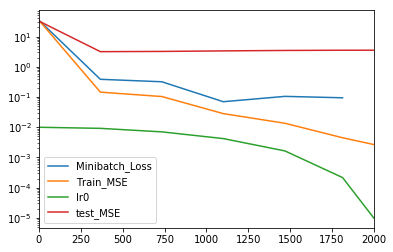

In [38]:
df_mlp.plot()
plt.yscale('log')

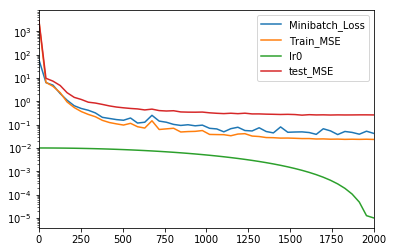

In [39]:
df_e.plot()
plt.yscale('log')

In [28]:

#df_e = trainer.logger.scalar_frame

sns.lineplot(y='test_MSE',data=df_all,hue="Model")
plt.yscale('log')
plt.show()

ValueError: Either both or neither of `x` and `y` must be specified (but try passing to `data`, which is more flexible).

In [21]:
#repmiddle = 30*T(0)+10*T(1)+5*T(2)+2*T(3)#+2*T(3,0)+2*T(2,1)+2*T(1,2)+2*T(0,3)
repmiddle =100*T(0)+30*T(1)+10*T(2)+3*T(3)#+2*T(3,0)+2*T(2,1)+2*T(1,2)+2*T(0,3)

In [22]:
repmiddle(e2)

2T(0)+2T(1)+2T(2)+T(3)+T(4) @ d=2

In [23]:
#(repmiddle*repmiddle.T).symmetric_subspace()[0]

In [24]:
#(repmiddle*repmiddle.T).size()

In [25]:
repmiddle*repmiddle#.T

4T(0)+8T(1)+12T(2)+12T(3)+12T(4)+8T(5)+5T(6)+2T(7)+T(8) @ d=2

In [26]:
from emlp.mlp import capped_tensor_product

In [27]:
v = repmiddle.show_subspace()

In [28]:
v

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970])

In [29]:
outrep,outv = cappedTensorProduct(repmiddle,v,repmiddle)

In [30]:
#(repmiddle*repmiddle).ranks

In [31]:
outrep.ranks

[(0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (3, 0),
 (4, 0),
 (0, 0),
 (0, 0),
 (1, 0),
 (1, 0),
 (2, 0),
 (2, 0),
 (3, 0),
 (4, 0)]

In [32]:
v

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970])

In [33]:
outv

tensor([  1.0000,   2.0000,   0.0000,   0.0000,   0.0000,   0.0000,  -3.5000,
         -0.5000,   0.5000,  -3.5000,  -5.5000,  -0.5000,   0.5000,  -5.5000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,  -1.0970,  11.2701,  -7.3964,  -7.3549,  -2.3831,   5.8674,
          0.3905,   1.4907,  -1.4907,   0.3905,   5.8674,   2.3831,  -7.3549,
          7.3964, -11.2701,  -1.0970,   1.0000,   1.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000])

In [34]:
outrep.drho(e2[0])@outv.numpy()

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -2.38418579e-07,  2.38418579e-07,
        2.38418579e-07,  2.38418579e-07,  2.38418579e-07,  2.38418579e-07,
        2.38418579e-07, -2.38418579e-07,  2.38418579e-07,  2.38418579e-07,
        2.38418579e-07, -2.38418579e-07,  2.38418579e-07, -2.38418579e-07,
       -2.38418579e-07, -2.38418579e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [21]:
outrep.drho(e2[0]).shape

(16, 16)

$SO(2): \quad 1,\_, \delta_{ij},\_, \epsilon_{ij}, ...$

In [14]:
for i in range(8):
    print(f"T({i}): {T(i)(O(2)).symmetric_subspace()[0]}")

T(0): 1
T(1): 0
T(2): 0
T(3): 0
T(4): 0
T(5): 0
T(6): 0
T(7): 0


In [16]:
from emlp.equivariant_subspaces import T
from emlp.groups import SO,O,C,D,Scaling,Parity,TimeReversal,Lorentz,SO13p,SO13,Symplectic
rep = T(2)(C(6))
A = rep.show_subspace()

In [2]:
T(0,2)(C(6))

T(2) @ d=2

In [4]:
import numpy as np
np.mean(np.zeros((0,3)))

nan

In [5]:
R = rep.G.sample()
Rrep = rep.rho(R)
print(Rrep@A.numpy())
print(A)

[-0.70710677  1.41421354 -1.41421354 -0.70710677]
tensor([-0.7071,  1.4142, -1.4142, -0.7071])


In [6]:
print(f"T({4}): {T(4)(e2).show_subspace().reshape(2,2,2,2)}")

NameError: name 'e2' is not defined

$SO(3): \quad 1, \_, \delta_{ij}, \epsilon_{ijk}, \delta_{ij}\delta_{k\ell}, \delta_{ik}\delta_{j\ell}, \delta_{jk}\delta_{i\ell}, ...$

In [11]:
for i in range(8):
    print(f"T({i}): {T(i)(e3).symmetric_subspace()[0]}")

T(0): 1
T(1): 0
T(2): 1
T(3): 1
T(4): 3
T(5): 6
T(6): 15
T(7): 36


$SO^+(1,3): \quad 1, \_, \delta_{\mu}^\nu, \eta_{\mu\nu}, \eta^{\mu\nu},\_,\epsilon_{\mu\nu\sigma\tau},\eta_{\mu\nu}\eta_{\sigma\tau},...$

In [5]:
for i in range(6):
    for j in range(i+1):
        print(f"T{i-j,j}: {T(i-j,j)(SO13).symmetric_subspace()[0]}")

T(0, 0): 1
T(1, 0): 0
T(0, 1): 0
T(2, 0): 1
T(1, 1): 1
T(0, 2): 1
T(3, 0): 0
T(2, 1): 0
T(1, 2): 0
T(0, 3): 0
T(4, 0): 3
T(3, 1): 3
T(2, 2): 3
T(1, 3): 3
T(0, 4): 3
T(5, 0): 0
T(4, 1): 0
T(3, 2): 0
T(2, 3): 0
T(1, 4): 0
T(0, 5): 0


#### $SO(2)_{xy}$ in $\mathbb{R}^3$

In [7]:
for i in range(8):
    print(f"T({i}): {T(i)(e3[:1]).symmetric_subspace()[0]}")

T(0): 1
T(1): 1
T(2): 3
T(3): 7
T(4): 19
T(5): 51
T(6): 141
T(7): 393


Trivial in $\mathbb{R}^3$

In [15]:
for i in range(8):
    print(f"T({i}): {T(i)(0*e3[:1]).symmetric_subspace()[0]}")

T(0): 1
T(1): 3
T(2): 9
T(3): 27
T(4): 81
T(5): 243
T(6): 729
T(7): 2187


$\mathrm{Sp}(1)$ Symplectic group

In [22]:
for i in range(6):
    for j in range(i+1):
        print(f"T{i-j,j}: {T(i-j,j)(Symplectic(2)).symmetric_subspace()[0]}")

T(0, 0): 1
T(1, 0): 0
T(0, 1): 0
T(2, 0): 1
T(1, 1): 1
T(0, 2): 1
T(3, 0): 0
T(2, 1): 0
T(1, 2): 0
T(0, 3): 0
T(4, 0): 3
T(3, 1): 3
T(2, 2): 3
T(1, 3): 3
T(0, 4): 3
T(5, 0): 0
T(4, 1): 0
T(3, 2): 0
T(2, 3): 0
T(1, 4): 0
T(0, 5): 0


In [21]:
T(2,0)(Symplectic(2)).show_subspace()

tensor([-1.2343,  0.0000,  0.0000,  0.0000,  0.0000, -0.9449, -0.2894,  0.0000,
         0.0000, -0.2894, -0.9449,  0.0000,  0.0000,  0.0000,  0.0000, -1.2343])

In [9]:
import numpy as np

In [10]:
np.ones(3)@e3

array([[ 0., -1.,  1.],
       [-1.,  0.,  1.],
       [-1.,  1.,  0.]])

In [11]:
e3.shape

(3, 3, 3)

In [1]:
from emlp.groups import *

In [6]:
M = O13.sample()

In [7]:
eta = np.eye(4)
eta[0,0]=-1

In [8]:
M.T@eta@M-eta

array([[-1.11022302e-15, -5.01459875e-16, -1.71810289e-16,
         1.19624964e-16],
       [-5.01459875e-16, -3.33066907e-16, -1.36956663e-16,
        -9.35976936e-17],
       [-1.71810289e-16, -1.36956663e-16,  2.22044605e-16,
         6.47558888e-17],
       [ 1.19624964e-16, -9.35976936e-17,  6.47558888e-17,
         0.00000000e+00]])

In [31]:
A = SO(2).sample()

In [32]:
A@A.T

array([[1.00000000e+00, 7.21013798e-17],
       [7.21013798e-17, 1.00000000e+00]])

In [8]:
sum([[i for i in range(j)] for j in range(4)],[])

[0, 0, 1, 0, 1, 2]

In [5]:
O(2).discrete_generators

array([[[-1., -0.],
        [-0., -1.]]])

In [11]:
import numpy as np
np.concatenate([np.zeros((3,4)),np.zeros((0,4))])

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [4]:
np.concatenate([np.arange(3),5+np.arange(3)]).reshape(2,3)

array([[0, 1, 2],
       [5, 6, 7]])

In [14]:
import collections
from emlp.equivariant_subspaces import size
def tensor_indices_dict(rep):
    index_dict = collections.defaultdict(list)
    i=0
    for rank in rep.ranks:
        i_end = i+size(rank,rep.d)
        index_dict[rank].append(np.arange(i,i_end))
        i = i_end
    return {rank:np.concatenate(ids) for rank,ids in index_dict.items()}

In [16]:
tensor_indices_dict((T(0)+3*T(2)+2*T(1)+T(0))(SO(3)))

{(0, 0): array([ 0, 34]),
 (2,
  0): array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 (1, 0): array([28, 29, 30, 31, 32, 33])}

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import dill,pickle

In [ ]:
with open(os.path.expanduser('~/equivariant-MLP/experiments/EMLP_synthetic_study/results.df'),'rb') as f:
    df = pickle.load(f)

In [190]:
#df

In [191]:
df.loc[df['network']=='MLP','group']='MLP'
df_fr = df[df['dataset']=='Fr']
df_i = df[df['dataset']=='Inertia']

Text(0.5, 1.0, 'Fitting Moment of Inertia (5 point masses)')

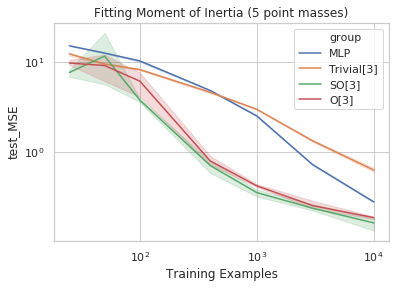

In [203]:
sns.set(style='whitegrid')
sns.lineplot(data=df_i,x='train',y='test_MSE',hue='group')
plt.xlabel('Training Examples')
plt.yscale('log')
plt.xscale('log')
plt.title("Fitting Moment of Inertia (5 point masses)")
#plt.xlim(25,10**4)

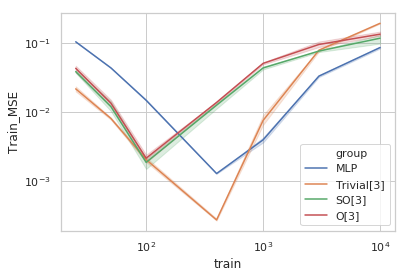

In [193]:
sns.lineplot(data=df_i,x='train',y='Train_MSE',hue='group')
plt.yscale('log')
plt.xscale('log')

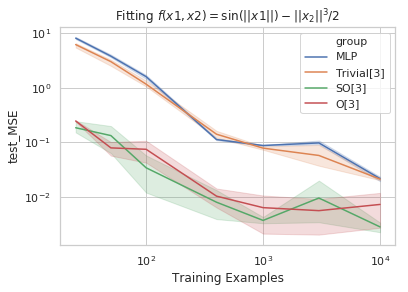

In [204]:
plt.title(r"Fitting $f(x1,x2) = \mathrm{sin}(\||x1\||)-\||x_2\||^3/2$")
sns.lineplot(data=df_fr,x='train',y='test_MSE',hue='group')
plt.xlabel('Training Examples')
plt.yscale('log')
plt.xscale('log')

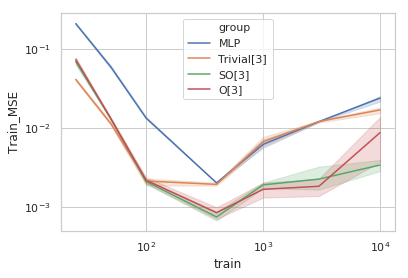

In [195]:
sns.lineplot(data=df_fr,x='train',y='Train_MSE',hue='group')
plt.yscale('log')
plt.xscale('log')

In [1]:
from emlp.groups import Symplectic

In [11]:
Sp = Symplectic(2)

In [12]:
S = Sp.sample()

In [4]:
import numpy as np

In [14]:
J = np.array([[0, 1],[-1.,0]])
Omega = np.kron(J,np.eye(2))

In [15]:
S.T@Omega@S-Omega

array([[-1.36100489e-16, -9.54867495e-17,  0.00000000e+00,
         8.70343569e-18],
       [-2.75402255e-17, -7.19633725e-17,  6.39748495e-17,
         2.22044605e-16],
       [-2.22044605e-16, -7.59323587e-17,  1.59813831e-17,
         1.96336273e-16],
       [ 9.48105133e-17, -2.22044605e-16, -2.14029412e-16,
         1.67250872e-17]])

In [23]:
0*[1]

[]

In [8]:
from emlp.mlp import uniform_rep,uniform_allocation
from emlp.groups import Symplectic,Lorentz,SO,O

In [9]:
SO3 = SO(3)

In [10]:
uniform_rep(384,SO3)

102T(0)+34T(1)+11T(2)+3T(3) @ d=3

In [7]:
uniform_rep(384,Lorentz).size()

384

In [6]:
143//2**4

8

In [9]:
import scipy as sp
import scipy.special
from emlp.equivariant_subspaces import T

In [12]:
def binomial_allocation(N,rank):
    if N==0: return 0
    C = lambda r,k: int(sp.special.binom(r,k))
    rep = sum(T(k,rank-k)*((C(rank,k)*N)//2**rank) for k in range(rank+1))
    return rep + binomial_allocation(N-len(rep),rank)

In [13]:
sp.special.binom(4,3)

4.0